In [1]:
import sys
sys.path.append('../')
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from shapely import geometry
from utils import *
tqdm.pandas()

plt.rcParams["figure.figsize"] = [12,6]

C:\Users\paulo\anaconda3\envs\faces\lib\site-packages\tqdm\std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
dataset360 = pd.read_pickle('../dataframes/dataset360_detections.pkl')
dataset360.head(2)

,image_path,metadata,fold,phi,theta,r_h,faces,circular_perimeter_faces,detections_mtcnn,detectionsViewD_3,detectionsViewD_4,detectionsViewD_5,detectionsViewD_6,detectionsViewD_7,detectionsViewD_8,detectionsViewD_9,detectionsViewD_10,detections_sphere_mtcnn
0,../data/dataset_360/FDDB-fold-01\2002_07_19_bi...,../data/dataset_360/FDDB-fold-01\2002_07_19_bi...,FDDB-fold-01,57,136,0.454058,"[[(140, 483), (160, 483), (180, 482), (138, 50...","[[(140, 483), (160, 483), (180, 482), (184, 50...","[[(142, 488), (175, 488), (175, 525), (142, 52...","[[(147, 487), (165, 489), (184, 491), (181, 50...","[[(141, 488), (160, 489), (179, 488), (182, 50...","[[(137, 490), (156, 489), (175, 487), (180, 50...","[[(133, 492), (152, 490), (172, 488), (179, 50...","[[(130, 492), (150, 489), (168, 486), (178, 50...","[[(132, 491), (150, 488), (168, 484), (178, 50...","[[(130, 493), (148, 490), (166, 486), (177, 50...","[[(137, 490), (155, 489), (173, 487), (179, 50...",[]
1,../data/dataset_360/FDDB-fold-01\2002_07_19_bi...,../data/dataset_360/FDDB-fold-01\2002_07_19_bi...,FDDB-fold-01,85,-142,0.552233,"[[(1122, 578), (1170, 578), (1215, 575), (1109...","[[(1122, 578), (1170, 578), (1215, 575), (1248...",[],"[[(1149, 579), (1191, 585), (1243, 589), (1229...","[[(1149, 578), (1189, 584), (1237, 588), (1222...","[[(1128, 581), (1169, 581), (1210, 579), (1234...","[[(1125, 580), (1170, 581), (1219, 580), (1237...","[[(1134, 580), (1177, 582), (1225, 581), (1242...","[[(1129, 581), (1176, 584), (1229, 584), (1238...","[[(1118, 585), (1163, 585), (1206, 582), (1232...","[[(1103, 588), (1148, 585), (1192, 581), (1228...",[]


## mAP

In [3]:
def compute_metrics(df, gt_column, pred_column, threshold = 0.5):
    total_faces = df.circular_perimeter_faces.apply(len).sum()

    tps = []
    fps = []

    tp = 0
    fp = 0
    for index , row in df.iterrows(): 
        ground_truths = row['circular_perimeter_faces']
        gt_polys = [geometry.Polygon(adjust_bounds(gt)).convex_hull for gt in ground_truths]
        #gt_polys = [geometry.Polygon(gt) for gt in ground_truths]

        tests = row[pred_column]   
        for test in tests:               
            ious = []

            for gt_poly in gt_polys:            
                gt_test = geometry.Polygon(adjust_bounds(test)).convex_hull
                try:
                    iou = gt_poly.intersection(gt_test).area/gt_poly.union(gt_test).buffer(0).area
                except:
                    iou = 0
                ious.append(iou)

            if len(gt_polys) > 0:
                max_iou = np.argmax(ious)

                if ious[max_iou] > threshold:#true positive
                    tp+=1

                    gt_polys.pop(max_iou)

                else:
                    fp += 1
            else: 
                fp += 1

            #print(f'tp: {tp}, fp: {fp}')
            tps.append(tp)
            fps.append(fp)

    tps = np.array(tps)
    fps = np.array(fps)
    
    precision = tps/(tps+fps)
    recall = tps/total_faces

    eval_df = pd.DataFrame({'precision':precision, 'recall':recall})
    
    prec_at_rec = []
    
    ##map
    for recall_level in np.linspace(0.0, 1.0, 11):
        try:
            x = eval_df[eval_df['recall'] >= recall_level]['precision']
            prec = max(x)
        except Exception as e:
            prec = 0.0
        prec_at_rec.append(prec)
    avg_prec = np.mean(prec_at_rec)

    #print('11 point precision is ', prec_at_rec)
    #print(f'mAP.{threshold*100} is ', avg_prec)

    return avg_prec, precision, recall, prec_at_rec, tps, fps

In [4]:
total_images_faces = lambda d: f'Faces: {d.circular_perimeter_faces.apply(len).sum()} Images:{len(d.circular_perimeter_faces)}'

## Evaluate Dataset

In [5]:
def evaluate_dataset(dataset, threshold = 0.50):
    d_column_prefix = 'detectionsViewD_'
    d_numbers = [int(c.split('_')[-1]) for c in dataset.columns[::-1] if c.startswith(d_column_prefix)]
    d_numbers.sort()
    mAPs = []
    baseline = []
    
    mAP_baseline,_,_,_,_,_ = compute_metrics(dataset360, 'circular_perimeter_faces', 'detections_mtcnn', threshold = threshold) 
    for d_number in tqdm(d_numbers):
        d_column = d_column_prefix+str(d_number)

        mAP,_,_,_,_,_ = compute_metrics(dataset, 'circular_perimeter_faces', d_column, threshold = threshold) 
        mAPs.append(mAP)
        baseline.append(mAP_baseline)
        
    return d_numbers, mAPs, baseline

In [6]:
def plot_results(d_numbers, mAPs_50, baseline_50, mAPs_25, baseline_25):
    
    fig, axs = plt.subplots(1,2)
    
    axs[0].set_title('mAP.50 Results')
    axs[0].set_xlabel('Viewports Density')
    axs[0].set_ylabel('mAP')
    axs[0].plot(d_numbers, mAPs_50, label='mtcnn_view')
    axs[0].plot(d_numbers, baseline_50, label='mtcnn')
    axs[0].legend()

    axs[1].set_title('mAP.25 Results')
    axs[1].set_xlabel('Viewports Density')
    axs[1].set_ylabel('mAP')
    axs[1].plot(d_numbers, mAPs_25, label='mtcnn_view')
    axs[1].plot(d_numbers, baseline_25, label='mtcnn')
    axs[1].legend()
    plt.show()

## Overall

Faces: 5171 Images:2845


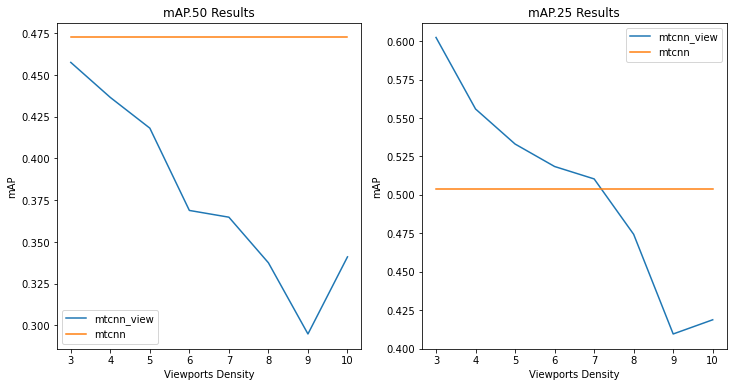

In [7]:
print(total_images_faces(dataset360))
d_numbers, mAPs_50, baseline_50 = evaluate_dataset(dataset360, threshold=0.50)
d_numbers, mAPs_25, baseline_25 = evaluate_dataset(dataset360, threshold=0.25)

plot_results(d_numbers, mAPs_50, baseline_50, mAPs_25, baseline_25)

## Close to Poles

In [8]:
poles = dataset360.loc[dataset360.phi.apply(abs) >= 60]
poles.shape

(983, 18)

Faces: 1770 Images:983


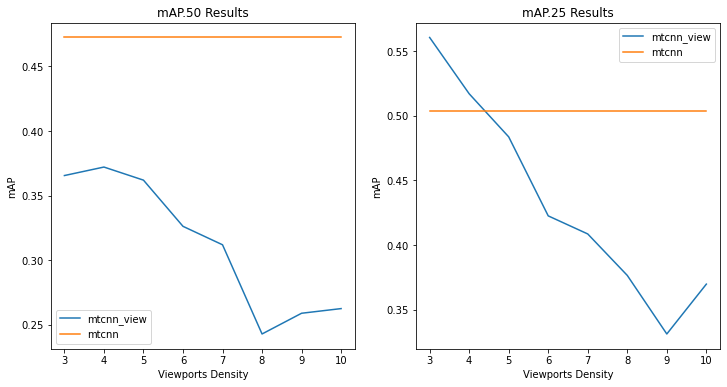

In [9]:
print(total_images_faces(poles))
d_numbers, mAPs_50, baseline_50 = evaluate_dataset(poles, threshold=0.50)
d_numbers, mAPs_25, baseline_25 = evaluate_dataset(poles, threshold=0.25)

plot_results(d_numbers, mAPs_50, baseline_50, mAPs_25, baseline_25)

## Close to Borders

In [10]:
borders = dataset360.loc[dataset360.theta.apply(abs) >= 170]
borders.shape

(146, 18)

Faces: 284 Images:146


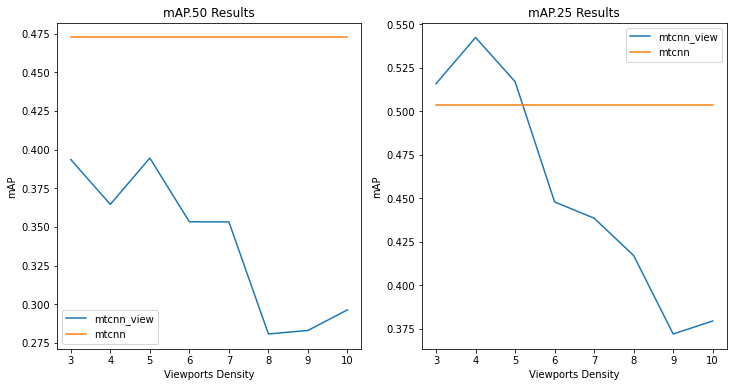

In [11]:
print(total_images_faces(borders))
d_numbers, mAPs_50, baseline_50 = evaluate_dataset(borders, threshold=0.50)
d_numbers, mAPs_25, baseline_25 = evaluate_dataset(borders, threshold=0.25)

plot_results(d_numbers, mAPs_50, baseline_50, mAPs_25, baseline_25)